In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
import os
from shutil import rmtree
from utils.enums import ToolEnum, FeatureEnum as FE, FeatureDirectionEnum as FDE, FeatureTypeEnum as FTE
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import alignment.ensemble
import alignment.dataset
import utils.plots
from features.labels import LabelCandidateExtractor
from features.pairwise import _CUSTOM_METRICS
from utils.dataloading import load_balibase_results

In [39]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

run_suffix = ""
# run_suffix = "_muscle5"
# run_suffix = "_reduced"

BENCHMARKS = ["balibase3/RV11" + run_suffix, "balibase3/RV12" + run_suffix]

OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"
TOOL_DIR = OUTPUT_DIR / "{dataset}" / "{tool}"

DATASETS = OUTPUT_DIR.format(benchmark=BENCHMARKS[0]).listdir(dirs_only=True)
_file_suffix_map = {"": "_multi", "_muscle5": "_muscle5", "_reduced": "_reduced"}
file_suffix = _file_suffix_map[run_suffix]

benchmark_mapping = dict(zip(BENCHMARKS, ["RV11 (hard)", "RV12 (easy)"]))

In [40]:
missing = [
    "BBS11004.msf",
]
for missing in missing:
    for benchmark in BENCHMARKS:
        if missing in OUTPUT_DIR.format(benchmark=benchmark).listdir(dirs_only=True):
            # rmtree(OUTPUT_DIR.format(benchmark=benchmark) / missing)
            print(benchmark)

balibase3/RV11


In [41]:
id_cols = ["benchmark", "dataset", "tool"]
(
    unaligned_features,
    aligned_features,
    aligned_cols,
    reference_features,
    confusion_features,
    _,
    _,
) = load_balibase_results(BENCHMARKS)

tool
Mafft_FFT-NS-2    1296
Mafft_L-INS-i     1296
Mafft_G-INS-i     1296
ClustalO          1296
Muscle5           1296
Muscle3           1296
Name: count, dtype: int64
dataset
BB12011.msf     48
BBS11007.msf    48
BBS11014.msf    48
BBS11017.msf    48
BB11021.msf     48
Name: count, dtype: int64
unaligned: (162, 87)
aligned: (1134, 205)
confusion: (1134, 18)
reference: (972, 28)


In [29]:
aligned_features.isna().mean(axis=0).sort_values(ascending=False)[:10]

std_pythia_score                0.002058
median_pythia_score             0.002058
mean_pythia_score               0.002058
max_pythia_score                0.002058
min_pythia_score                0.002058
min_seq_length_taxa_ratio       0.000000
max_seq_length_taxa_ratio       0.000000
mean_seq_length_taxa_ratio      0.000000
median_seq_length_taxa_ratio    0.000000
std_seq_length_taxa_ratio       0.000000
dtype: float64

In [42]:
# candidates = FE.extract_from_df(
#     aligned_features,
#     type_enum=FTE.DISTANCE,
#     statistic_filter="mean_",
#     keep_string_cols=False,
# ).columns.to_list()
# candidates.append("dispersion")
candidates = [
    FE.HOMOLOGY_POS_DIST,
    FE.HOMOLOGY_SEQ_DIST,
    FE.SSP_DIST,
    FE.CONFUSION_ENTROPY,
    FE.CONFUSION_DISPLACEMENT,
    FE.CONFUSION_SET,
    FE.DISPERSION,
    FE.COLUMN_CONFIDENCE,
    FE.PERC_HASH_HAMMING,
    # FE.GAP_DELTA_DISTANCE,
]
candidate_names = [
    "mean_homology_pos_dist",
    "mean_homology_seq_dist",
    "mean_symmetrized_sp_dist",
    "mean_confusion_entropy",
    "mean_confusion_displacement",
    "mean_confusion_set",
    "dispersion",
    "column_confidence",
    "mean_perc_hash_hamming_dist_16bit",
    # "novel",
]
# agg_names = [
#     # "mean_homology_pos_dist",
#     # "dispersion",
#     "mean_confusion_entropy",
#     "mean_confusion_displacement",
# ]
# aligned_features["novel"] = (
#     (
#         (aligned_features[agg_names] - aligned_features[agg_names].mean(axis=0))
#         / aligned_features[agg_names].std(axis=0)
#     )
#     .mean(axis=1)
#     .copy()
# )
# reference_features["novel"] = ((
#         (reference_features[agg_names] - reference_features[agg_names].mean(axis=0))
#         / reference_features[agg_names].std(axis=0)
#     )
#     .mean(axis=1)
#     .copy())
# aligned_features["novel"] = aligned_features[agg_names].mean(axis=1).copy()
# reference_features["novel"] = reference_features[agg_names].mean(axis=1).copy()
tool_name = "Muscle5_32" if file_suffix == "_muscle5" else "all"
best_ens_df = aligned_features[aligned_features.tool == tool_name].sort_values(
    id_cols, ignore_index=True
)
best_ref_df = (
    reference_features.sort_values(id_cols, ignore_index=True)
    .groupby(["benchmark", "dataset"], as_index=False)
    .mean(numeric_only=True)
)

# Correct outliers in colconf
best_ref_df.loc[best_ref_df["column_confidence"] > 1, "column_confidence"] = np.nan
best_ref_df["column_confidence"] = 1 - best_ref_df["column_confidence"]
best_ens_df["column_confidence"] = 1 - best_ens_df["column_confidence"]

# test_methods = ["mean_" + FE.HOMOLOGY_POS_DIST, FE.DISPERSION]
# temp = best_ens_df.loc[:, test_methods] + 1e-8
# temp = 2 / (np.ones_like(test_methods) / temp).sum(axis=1)
# best_ens_df["mean_perc_hash_hamming_dist_16bit"] = temp.astype(float)
# temp = best_ref_df.loc[:, test_methods]
# temp = 2 / (np.ones_like(test_methods) / temp).sum(axis=1)
# best_ref_df["mean_perc_hash_hamming_dist_16bit"] = temp.astype(float)


corr_coefs = []
for name in candidate_names:
    corr_coefs.append(best_ens_df[name].corr(best_ref_df[name]))
    corr_df = pd.concat((best_ens_df[name], best_ref_df[name]), axis=1)
    corr_df.columns = ["ensemble", "reference"]

corr_coefs = pd.Series(corr_coefs, index=candidate_names).sort_values(ascending=False)
# corr_coefs.to_json(RESULT_DIR / "balibase3" / f"correlations{file_suffix}.json")
print(corr_coefs)

mean_homology_pos_dist               0.967836
mean_symmetrized_sp_dist             0.965167
mean_homology_seq_dist               0.962330
dispersion                           0.960706
column_confidence                    0.954256
mean_confusion_entropy               0.949898
mean_perc_hash_hamming_dist_16bit    0.920120
mean_confusion_displacement          0.893865
mean_confusion_set                   0.862618
dtype: float64


In [ ]:
test_methods = ["mean_" + FE.HOMOLOGY_POS_DIST, FE.DISPERSION]
temp = best_ens_df.loc[:, test_methods] + 0.0001
temp = 2 / (np.ones_like(test_methods) / temp).sum(axis=1)
ref_free = temp.astype(float)
temp = best_ref_df.loc[:, test_methods]
temp = 2 / (np.ones_like(test_methods) / temp).sum(axis=1)
ref_based = temp.astype(float)

homology_pos_dist
homology_seq_dist
symmetrized_sp_dist
confusion_entropy
confusion_displacement
confusion_set
dispersion
column_confidence
perc_hash_hamming_dist


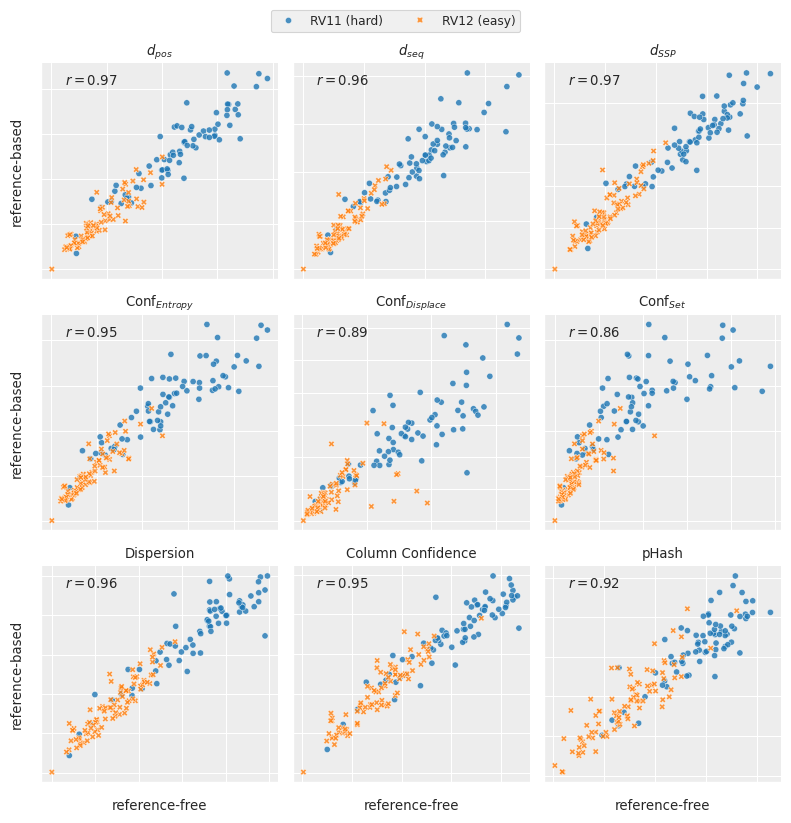

In [43]:
import seaborn.objects as so

# Plot sorted candidates
n_candidates = (corr_coefs >= 0.9).sum()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
t = 0
for candidate, name in zip(candidates, candidate_names):
    i = t // 3
    j = t % 3
    corr_df = pd.concat((best_ens_df[name], best_ref_df[name]), axis=1)
    corr_df.columns = ["reference-free", "reference-based"]
    sn.scatterplot(
        corr_df,
        x="reference-free",
        y="reference-based",
        hue=best_ens_df.benchmark,
        style=best_ens_df.benchmark,
        s=20,
        alpha=0.8,
        ax=axes[i, j],
        legend="auto" if t == 0 else False,
    )
    axes[i, j].text(
        x=0.1,
        y=0.9,
        transform=axes[i, j].transAxes,
        s="$r = $" + f"{corr_df.corr().iloc[1, 0]:.2f}",
    )
    axes[i, j].set_xticklabels([])
    axes[i, j].set_yticklabels([])
    if i != 2:
        axes[i, j].set_xlabel("")
    if j != 0:
        axes[i, j].set_ylabel("")
    print(candidate)
    title = candidate.pretty
    # if candidate == FE.PERC_HASH_HAMMING:
    #     title += " (16 Bit)"
    axes[i, j].set_title(title)
    t += 1

legend_labels = axes[0, 0].get_legend_handles_labels()[1]
legend_labels = [benchmark_mapping[label] for label in legend_labels]
plt.figlegend(
    axes[0, 0].get_legend_handles_labels()[0],
    legend_labels,
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
)
axes[0, 0].get_legend().remove()
fig.tight_layout()
plt.show()

fig.savefig(
    RESULT_DIR / "balibase3" / f"correlations_ensemble_reference{file_suffix}.svg",
    bbox_inches="tight",
)

dispersion


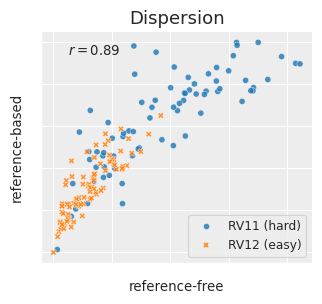

In [33]:
# Now, let's recreate this plot in a new figure
fig = plt.figure(figsize=(3.5, 3))
fig.tight_layout()
candidate = FE.DISPERSION
corr_df = pd.concat((best_ens_df[candidate], best_ref_df[candidate]), axis=1)
# corr_df = pd.concat((best_ens_m5_df[candidate], best_ref_m5_df[candidate]), axis=1)
corr_df.columns = ["reference-free", "reference-based"]
sn.scatterplot(
    corr_df,
    x="reference-free",
    y="reference-based",
    hue=best_ens_df.benchmark,
    style=best_ens_df.benchmark,
    s=20,
    alpha=0.8,
    legend="auto",
)
fig.gca().text(
    x=0.1,
    y=0.9,
    transform=fig.gca().transAxes,
    s="$r = $" + f"{corr_df.corr().iloc[1, 0]:.2f}",
)
fig.gca().set_xticklabels([])
fig.gca().set_yticklabels([])
print(candidate)
title = candidate.pretty
# if candidate == FE.PERC_HASH_HAMMING:
#     title += " (16 Bit)"
fig.gca().set_title(title, fontsize=13)
fig.gca().get_legend().set_title("")
# plt.legend()
legend_handles, legend_labels = fig.gca().get_legend_handles_labels()
legend_labels = [benchmark_mapping[label] for label in legend_labels]
plt.legend(legend_handles, legend_labels)

fig.savefig(RESULT_DIR / "balibase3" / f"corr_dispersion{file_suffix}.svg")

In [34]:
corr_coefs_all = pd.read_json(
    RESULT_DIR / "balibase3" / "correlations_multi.json", typ="series"
)
corr_coefs_m5_16 = pd.read_json(
    RESULT_DIR / "balibase3" / "correlations_muscle5.json", typ="series"
)
corr_coefs_df = pd.concat((corr_coefs_all, corr_coefs_m5_16), axis=1)
corr_coefs_df = corr_coefs_df.loc[candidate_names]
corr_coefs_df.columns = ["Multi-Aligner", "Uni-Aligner"]
corr_coefs_df = pd.melt(
    corr_coefs_df,
    var_name="Ensemble",
    value_name=f"Correlation",
    ignore_index=False,
)
corr_coefs_df = corr_coefs_df.reset_index(names="Method")

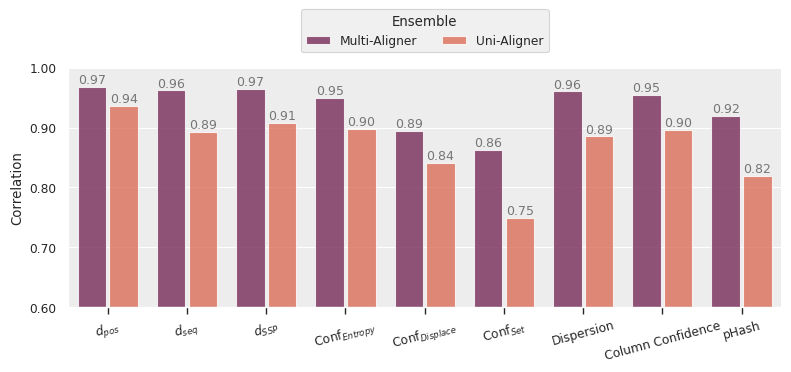

In [35]:
pretty_names = []
for candidate in candidates:
    name = candidate.pretty
    # if candidate == FE.PERC_HASH_HAMMING:
    #     name += " (16 Bit)"
    pretty_names.append(name)

plt.figure(figsize=(8, 4))
ax = sn.barplot(
    corr_coefs_df,
    x="Method",
    y=f"Correlation",
    hue="Ensemble",
    palette="rocket",
    alpha=0.8,
    gap=0.1,
)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=9,
        xytext=(0, 5),
        alpha=0.6,
        textcoords="offset points",
    )

_ = ax.set_xticks(ax.get_xticks(), pretty_names, rotation=15, ha="center")
ax.tick_params(axis="x", which="both", bottom=True, top=False)
# _ = ax.set_xticklabels()
# _ = ax.set_xticks(np.arange(9))
_ = ax.set_xlabel("")
ax.set_ylim(0.6, 1)
yticks = np.linspace(0.6, 1, 5)
_ = ax.set_yticks(yticks)
yticklabels = map("{:.2f}".format, yticks)

_ = ax.set_yticklabels(yticklabels)
sn.move_legend(ax, loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.27))
plt.tight_layout()
plt.savefig(
    RESULT_DIR / "balibase3" / "correlations_comparison_muscle5-vs-all.svg",
    bbox_inches="tight",
)

Index(['Data Source', 'benchmark', 'dataset', 'Method', 'Value'], dtype='object')


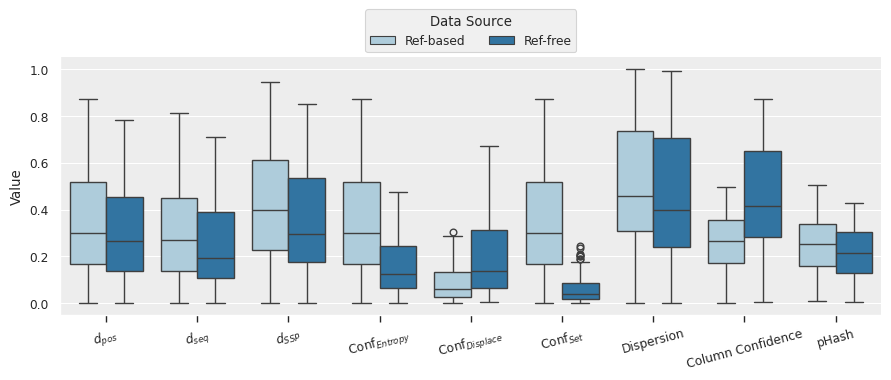

In [25]:
best_names = ["mea"]
plot_df_ens = best_ens_df.sort_values(id_cols, ignore_index=True)
plot_df_ref = best_ref_df.sort_values(["benchmark", "dataset"], ignore_index=True)
plot_df_ens["Data Source"] = "Ref-free"
plot_df_ref["Data Source"] = "Ref-based"
plot_df = pd.concat(
    (
        plot_df_ref[candidate_names + ["Data Source"]],
        plot_df_ens[candidate_names + ["Data Source"]],
    ),
    axis=0,
)
plot_df.columns = pretty_names + ["Data Source"]
plot_df = pd.concat((plot_df, plot_df_ens[["benchmark", "dataset"]]), axis=1)
fig = plt.figure(figsize=(9, 4))
plot_df = plot_df.melt(
    id_vars=["Data Source", "benchmark", "dataset"],
    value_vars=pretty_names,
    var_name="Method",
    value_name="Value",
)
print(plot_df.columns)
sn.boxplot(
    plot_df,
    x="Method",
    y="Value",
    hue="Data Source",
    # bw_adjust=0.3,
    palette=sn.color_palette("Paired")[:2],
)
_ = fig.gca().set_xticks(fig.gca().get_xticks(), pretty_names, rotation=15, ha="center")
fig.gca().tick_params(axis="x", which="both", bottom=True, top=False)
sn.move_legend(fig.gca(), loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.21))
_ = plt.xlabel("")
fig.tight_layout()
fig.savefig(RESULT_DIR / "balibase3" / "violin_score_distribution.svg")

In [36]:
_, af_muscle5, _, rf_muscle5, _, _, _ = load_balibase_results(
    ["balibase3/RV11_muscle5", "balibase3/RV12_muscle5"]
)
best_ens_m5_df = af_muscle5[af_muscle5.tool == "Muscle5_32"].sort_values(
    id_cols, ignore_index=True
)

best_ref_m5_df = (
    rf_muscle5[rf_muscle5.tool == "Muscle5_32"]
    .sort_values(id_cols, ignore_index=True)
    .groupby(["benchmark", "dataset"], as_index=False)
    .mean(numeric_only=True)
)

tool
Muscle5_32    20736
Muscle5_16    10368
Muscle5_8      5184
Muscle5_4      2577
Muscle5_2      1289
Name: count, dtype: int64
dataset
BBS11004.msf    233
BB12011.msf     241
BBS11017.msf    248
BB11021.msf     248
BB11014.msf     248
Name: count, dtype: int64
unaligned: (162, 87)
aligned: (972, 205)
confusion: (972, 18)
reference: (810, 28)


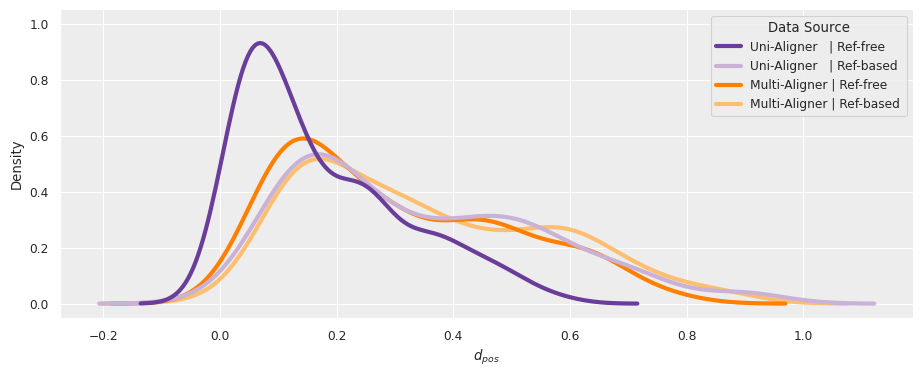

In [ ]:
feat_name = "mean_" + FE.HOMOLOGY_POS_DIST
plot_df = pd.concat(
    (
        best_ens_m5_df[feat_name],
        best_ref_m5_df[feat_name],
        best_ens_df[feat_name],
        best_ref_df[feat_name],
    ),
    axis=1,
)
plot_cols = [
    "Uni-Aligner   | Ref-free",
    "Uni-Aligner   | Ref-based",
    "Multi-Aligner | Ref-free",
    "Multi-Aligner | Ref-based",
]
plot_df.columns = plot_cols
# plot_df = (plot_df - plot_df.mean(axis=0)) / (plot_df.std(axis=0))
plot_df = pd.concat((plot_df, best_ens_df[id_cols]), axis=1).loc[
    best_ens_df.tool == "all"
]
plot_df = plot_df.drop("tool", axis=1).melt(
    id_vars=["benchmark", "dataset"],
    value_vars=plot_cols,
    var_name="Data Source",
    value_name="Value",
)

line_styles = []
plt.figure(figsize=(11, 4))
sn.kdeplot(
    plot_df,
    x="Value",
    hue="Data Source",
    palette=sn.color_palette("Paired")[6:10][::-1],
    multiple="layer",
    bw_adjust=0.9,
    cumulative=False,
    linewidth=3,
    # clip=[-0.2,1]
)
plt.ylim(-0.05, 1.05)
plt.xlabel(FE.HOMOLOGY_POS_DIST.pretty)
plt.savefig(
    RESULT_DIR / "balibase3" / "kde_d-pos_ensembles.svg",
)

['RV11 (hard)', 'RV12 (easy)', 'RV11 + RV12']


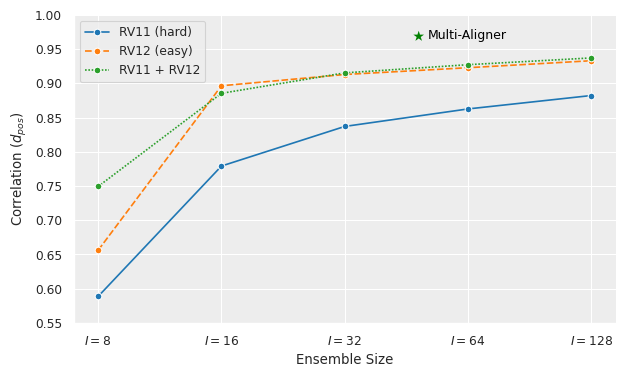

In [ ]:
ens_temp_df = af_muscle5.sort_values(id_cols, ignore_index=True)
ref_temp_df = rf_muscle5.sort_values(id_cols, ignore_index=True)
method = "mean_" + FE.HOMOLOGY_POS_DIST

tool_corrs = {}
tools = ["Muscle5_2", "Muscle5_4", "Muscle5_8", "Muscle5_16", "Muscle5_32"]
pretty = ["$I=8$", "$I=16$", "$I=32$", "$I=64$", "$I=128$"]
for benchmark in ens_temp_df.benchmark.unique():
    for tool, index in zip(tools, pretty):
        col_ens = ens_temp_df.loc[
            (ens_temp_df.tool == tool) & (ens_temp_df.benchmark == benchmark),
            method,
        ].reset_index(drop=True)
        col_ref = ref_temp_df.loc[
            (ref_temp_df.tool == tool) & (ref_temp_df.benchmark == benchmark),
            method,
        ].reset_index(drop=True)
        corr = col_ens.corr(col_ref)
        tool_corrs[(benchmark, index)] = corr

for tool, index in zip(tools, pretty):
    col_ens = ens_temp_df.loc[
        (ens_temp_df.tool == tool),
        method,
    ].reset_index(drop=True)
    col_ref = ref_temp_df.loc[
        (ref_temp_df.tool == tool),
        method,
    ].reset_index(drop=True)
    corr = col_ens.corr(col_ref)
    tool_corrs[("RV11 + RV12", index)] = corr

    # pass
# ref_temp_df
tool_corrs = pd.Series(tool_corrs)
tool_corrs = tool_corrs.reset_index()
cols = ["Benchmark", "Ensemble Size", f"Correlation ({FE.HOMOLOGY_POS_DIST.pretty})"]
tool_corrs.columns = cols
tool_corrs.Benchmark = tool_corrs.Benchmark.str.strip("_muscle5")

fig = plt.figure(figsize=(7, 4))
sn.lineplot(
    tool_corrs,
    x="Ensemble Size",
    y=f"Correlation ({FE.HOMOLOGY_POS_DIST.pretty})",
    hue="Benchmark",
    marker="o",
    style="Benchmark",
)
plt.ylim(0.55, 1)
# fig.gca().annotate('axes fraction',
#             xy=(0, 0), xycoords='data',
#             xytext=(0.36, 0.68), textcoords='data',)
plt.text(
    2.59,
    0.97,
    r"$\star$",
    fontsize=20,
    color="green",
    weight="bold",
    verticalalignment="center",
    horizontalalignment="center",
)
plt.text(
    2.67, 0.97, "Multi-Aligner", fontsize=9, color="black", verticalalignment="center"
)
legend_handles, legend_labels = fig.gca().get_legend_handles_labels()
legend_labels = [s.split("_")[0] for s in legend_labels]
legend_labels = [benchmark_mapping.get(label, label) for label in legend_labels]
print(legend_labels)
plt.legend(handles=legend_handles, labels=legend_labels)
plt.savefig(
    RESULT_DIR / "balibase3" / "correlation_progression_muscle5.svg",
)

<Axes: xlabel='tool', ylabel='tool'>

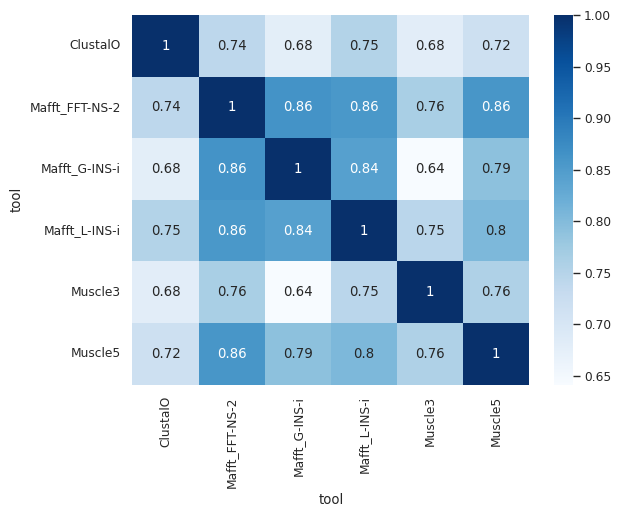

In [26]:
feat_name = "mean_" + FE.HOMOLOGY_POS_DIST
# test = aligned_features.loc[aligned_features.benchmark.str.contains("RV12"), id_cols + [feat_name]]
test = aligned_features[id_cols + [feat_name]]
test = pd.pivot(
    test, index=["benchmark", "dataset"], columns=["tool"], values=feat_name
).drop("all", axis=1)
sn.heatmap(test.corr(), annot=True, cmap="Blues")

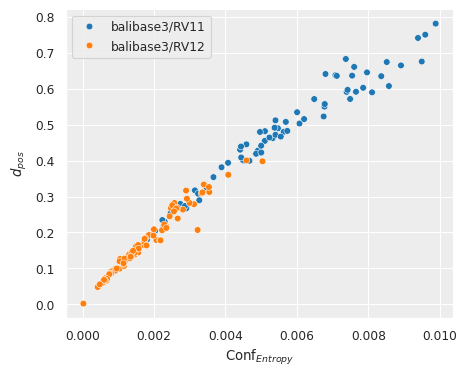

In [ ]:
r = best_ens_df["mean_" + FE.CONFUSION_ENTROPY].corr(
    best_ens_df["mean_" + FE.HOMOLOGY_POS_DIST]
)
fig = plt.figure(figsize=(5, 4))
sn.scatterplot(
    best_ens_df,
    x="mean_" + FE.CONFUSION_ENTROPY,
    y="mean_" + FE.HOMOLOGY_POS_DIST,
    hue="benchmark",
    # order=2,
    # palette=sn.color_palette("Paired"),
)
plt.xlabel(FE.CONFUSION_ENTROPY.pretty)
plt.ylabel(FE.HOMOLOGY_POS_DIST.pretty)
# plt.legend(ax.get_legend_handles_labels())
# plt.gca().legend().remove()
plt.legend(title="")

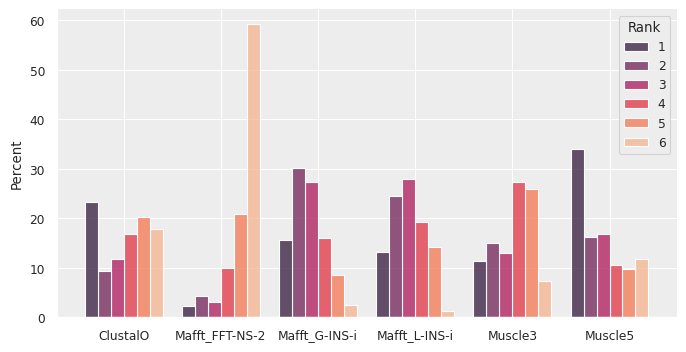

In [ ]:
feat_name = "mean_" + FE.HOMOLOGY_POS_DIST
perf_df = reference_features[id_cols + [feat_name]]
# perf_df = perf_df[perf_df.benchmark.str.contains("RV11")]
# test = test[test.tool != "all"]
# perf_df = perf_df.sort_values(feat_name)
# perf_df["rank"] = np.arange(len(perf_df))
perf_df = perf_df.sort_values(["benchmark", "dataset", feat_name], ignore_index=True)
# perf_df.rank()
perf_df["Rank"] = (
    perf_df[["benchmark", "dataset", feat_name]]
    .groupby(["benchmark", "dataset"])
    .rank(method="min")
    .astype("int")
)
# perf_df.value_counts("rank")
perf_df = perf_df.sort_values(id_cols, ignore_index=True)
perf_df = perf_df[["tool", "Rank"]]
perf_df["Rank"].value_counts()

fig = plt.figure(figsize=(8, 4))
fig.tight_layout()
ax = sn.histplot(
    perf_df,
    x="tool",
    hue="Rank",
    stat="percent",
    multiple="dodge",
    common_norm=False,
    shrink=0.8,
    palette=sn.color_palette("rocket"),
)
plt.xlabel("")
fig.savefig(
    RESULT_DIR / "balibase3" / "aligner_ranks_histogram.svg",
    bbox_inches="tight",
)

In [ ]:
import sklearn.metrics

feat_name = "mean_" + FE.HOMOLOGY_POS_DIST
_, af_reduced, _, rf_reduced, _, _, _ = load_balibase_results(
    ["balibase3/RV11_reduced", "balibase3/RV12_reduced"]
)

removed_tools = ["all", "Mafft_FFT-NS-2"]
ref_free_reduced = af_reduced[id_cols + [feat_name]].loc[af_reduced.tool == "all"]
ref_free_reduced = ref_free_reduced.sort_values(id_cols, ignore_index=True)
ref_based_reduced = rf_reduced[id_cols + [feat_name]].loc[rf_reduced.tool == "all"]
ref_based_reduced = (
    rf_reduced.sort_values(id_cols, ignore_index=True)
    .loc[:, id_cols + [feat_name]]
    .groupby(["benchmark", "dataset"], as_index=False)
    .mean(numeric_only=True)
)

# corr_coefs_reduced = []
# for name in [feat_name]:
corr_rr = ref_free_reduced[feat_name].corr(ref_based_reduced[feat_name])
corr_fr = best_ens_df[feat_name].corr(ref_based_reduced[feat_name])
corr_ff = best_ens_df[feat_name].corr(best_ref_df[feat_name])
print("Correlation:")
print("RR", corr_rr)
print("FR", corr_fr)
print("FF", corr_ff)

stdize = lambda y: (y - y.mean()) / y.std()
rmse = lambda y, y_hat: (((stdize(y) - stdize(y_hat)) ** 2).sum() / len(y)) ** 0.5

rmse_rr = rmse(ref_free_reduced[feat_name], ref_based_reduced[feat_name])
rmse_fr = rmse(best_ens_df[feat_name], ref_based_reduced[feat_name])
rmse_ff = rmse(best_ens_df[feat_name], best_ref_df[feat_name])

print("RMSE:")
print("RR", rmse_rr)
print("FR", rmse_fr)
print("FF", rmse_ff)
mape = lambda y, y_hat: ((y - y_hat).abs() / y_hat).sum() / len(y)
mape_rr = mape(ref_free_reduced[feat_name], ref_based_reduced[feat_name])
mape_fr = mape(best_ens_df[feat_name], ref_based_reduced[feat_name])
mape_ff = mape(best_ens_df[feat_name], best_ref_df[feat_name])

print("MAPE:")
print("RR", mape_rr)
print("FR", mape_fr)
print("FF", mape_ff)

tool
Mafft_L-INS-i    1296
Mafft_G-INS-i    1296
ClustalO         1296
Muscle5          1296
Muscle3          1296
Name: count, dtype: int64
dataset
BB12011.msf     40
BBS11007.msf    40
BBS11014.msf    40
BBS11017.msf    40
BB11021.msf     40
Name: count, dtype: int64
unaligned: (162, 87)
aligned: (972, 205)
confusion: (972, 13)
reference: (810, 28)
Correlation:
RR 0.9607484506851053
FR 0.9623932393471488
FF 0.9678364576179017
RMSE:
RR 0.27931793999170706
FR 0.2734030729710014
FF 0.2528438332134031
MAPE:
RR 0.22172704823993133
FR 0.1756293003485726
FF 0.1813324401357708


In [ ]:
def stdize(arr):
    return (arr - arr.mean()) / arr.std()


corr_coefs = []
n = len(best_ens_df)
for name in candidate_names:
    x = stdize(best_ens_df[name])
    y = stdize(best_ref_df[name])
    score = ((x - y) ** 2).sum() ** 0.5 / n
    # score = ((x - y).abs() / y.abs()).sum() / n
    corr_coefs.append(score)
    corr_df = pd.concat((best_ens_df[name], best_ref_df[name]), axis=1)
    corr_df.columns = ["ensemble", "reference"]

corr_coefs = pd.Series(corr_coefs, index=candidate_names)
print(corr_coefs)

mean_homology_pos_dist               0.019865
mean_homology_seq_dist               0.021499
mean_symmetrized_sp_dist             0.020673
mean_confusion_entropy               0.024794
mean_confusion_displacement          0.036086
mean_confusion_set                   0.041056
dispersion                           0.021957
column_confidence                    0.023532
mean_perc_hash_hamming_dist_16bit    0.031306
dtype: float64


<Axes: >

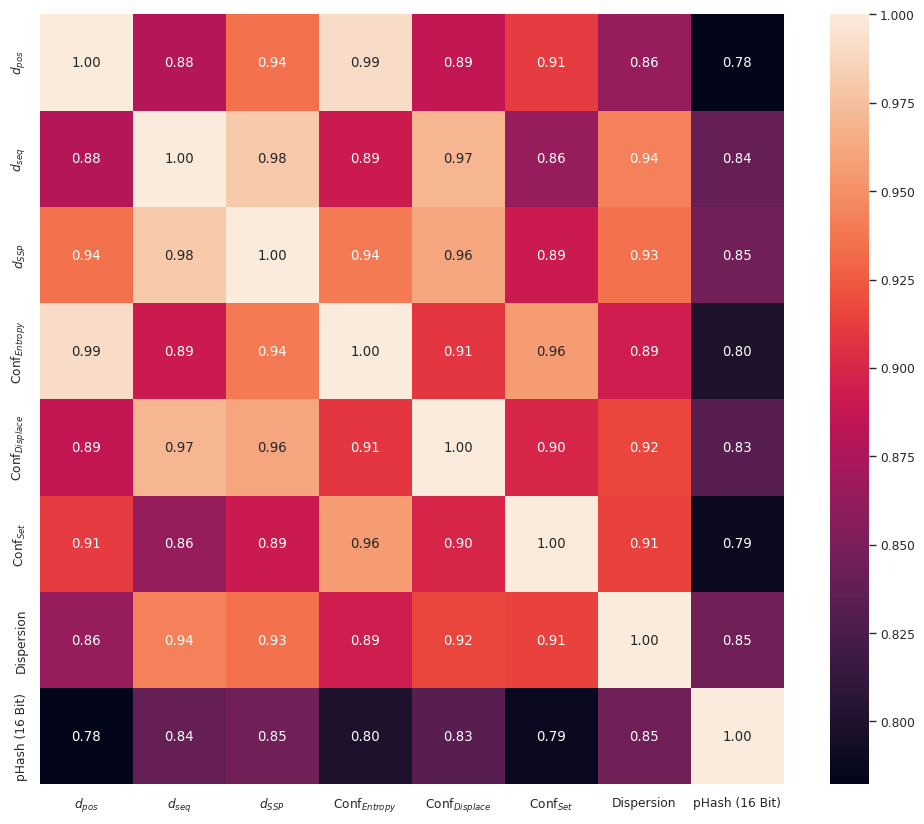

In [33]:
from features.pairwise import _CUSTOM_METRICS

names = ["mean_" + metric.name for metric in _CUSTOM_METRICS]
names.extend(
    [
        str(FE.DISPERSION),
        "mean_" + str(FE.CONFUSION_ENTROPY),
        "mean_" + str(FE.CONFUSION_SET),
        "mean_" + str(FE.CONFUSION_DISPLACEMENT),
    ]
)
# plot_df = FE.extract_from_df(aligned_features, type_enum=FTE.DISTANCE)
candidate_names_clean = candidate_names.copy()
candidate_names_clean.remove(FE.COLUMN_CONFIDENCE.value)
plot_df = best_ens_df.loc[best_ens_df.tool == "all", candidate_names_clean]
plot_df.columns = pretty_names

fig = plt.figure(figsize=(12, 10))
sn.heatmap(plot_df.corr(), annot=True, fmt=".2f")

Index(['tool', 'dataset', 'benchmark', 'data_type'], dtype='object')


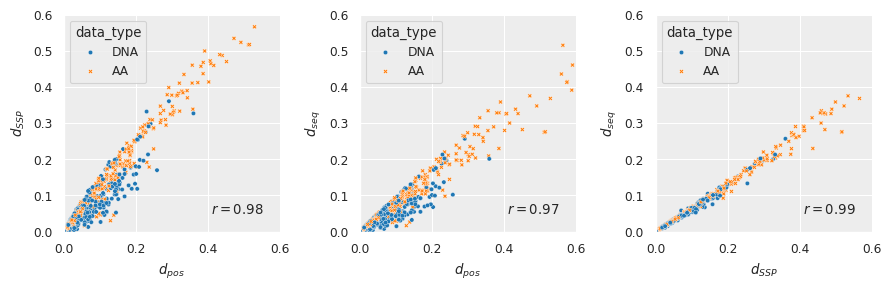

In [14]:
# Compare d_SSP, d_seq, and d_pos

%autoreload 2
from features.pairwise import _CUSTOM_METRICS


names = ["mean_" + metric.name for metric in _CUSTOM_METRICS]
print(aligned_features.select_dtypes("object").columns)
plot_df = FE.extract_from_df(
    aligned_features, type_enum=FTE.DISTANCE, statistic_filter="mean_"
)
plot_df = plot_df.loc[plot_df.tool == "all"]

pairs = [
    (FE.HOMOLOGY_POS_DIST, FE.SSP_DIST),
    (FE.HOMOLOGY_POS_DIST, FE.HOMOLOGY_SEQ_DIST),
    (FE.SSP_DIST, FE.HOMOLOGY_SEQ_DIST),
]
fig, axes = plt.subplots(1, len(pairs), figsize=(9, 3))
for i, (feat_x, feat_y) in enumerate(pairs):
    name_x = "mean_" + feat_x
    name_y = "mean_" + feat_y
    corr_coef = round(plot_df[name_x].corr(plot_df[name_y]), 2)
    sn.scatterplot(
        x=plot_df[name_x],
        y=plot_df[name_y],
        hue=plot_df["data_type"],
        style=plot_df["data_type"],
        alpha=1,
        s=10,
        ax=axes[i],
    )
    sn.move_legend(axes[i], "upper left")
    axes[i].set_xlim(0,0.6)
    axes[i].set_ylim(0,0.6)
    axes[i].set_xlabel(feat_x.pretty)
    axes[i].set_ylabel(feat_y.pretty)
    axes[i].text(x=0.41, y=0.05, s=r"$r = " + str(corr_coef) + "$")
fig.set_layout_engine("tight")

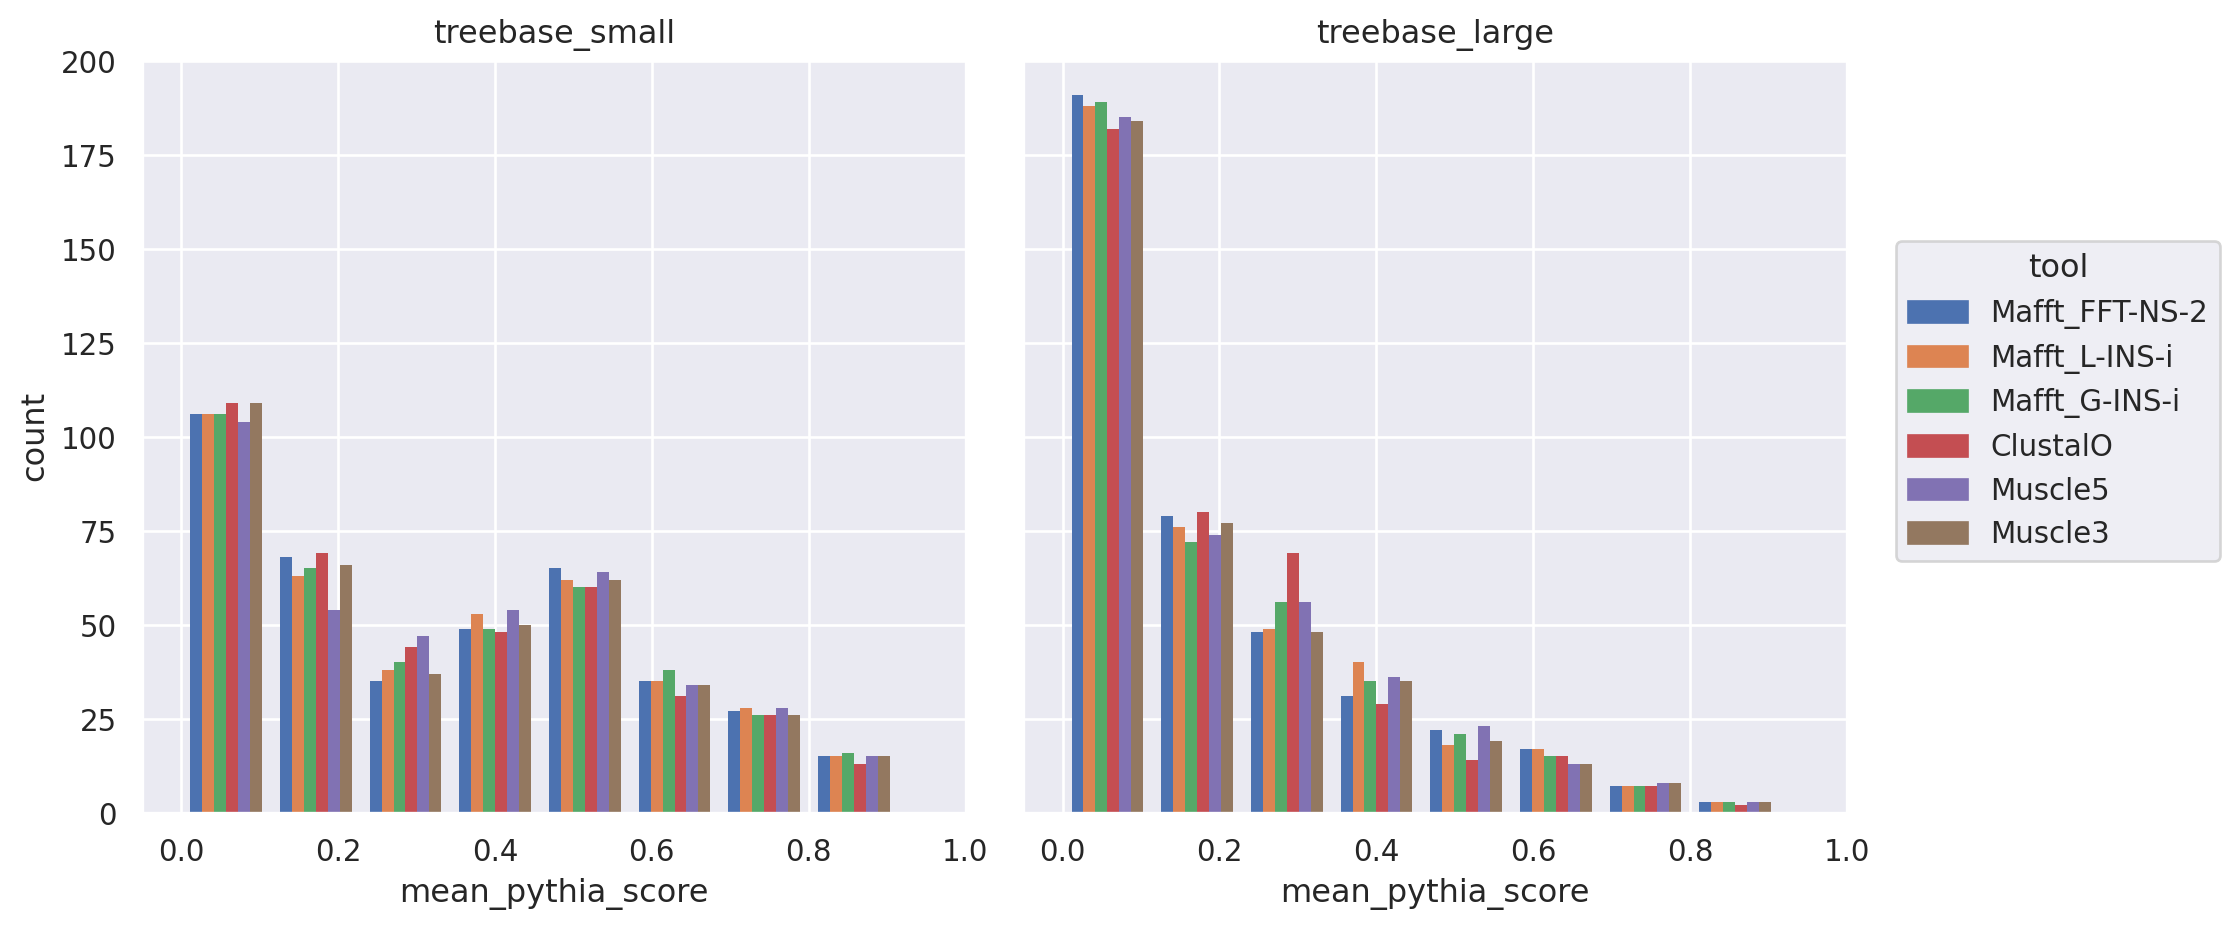

In [15]:
# Plot pythia distribution for different aligners
utils.plots.hist_facet_plot(
    aligned_features[aligned_features.tool != "all"],
    feature="mean_" + FE.PYTHIA_SCORE,
    color="tool",
    facet="benchmark",
)

In [ ]:
import sklearn.ensemble
import sklearn.linear_model
import sklearn.svm
from sklearn.model_selection import train_test_split
import sklearn.metrics

y = aligned_features.sort_values("dataset", ignore_index=True)
y = y.loc[y.tool == "all", "mean_" + FE.HOMOLOGY_POS_DIST]

X = unaligned_features.sort_values("dataset").select_dtypes(exclude="object")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)
rf = sklearn.ensemble.RandomForestRegressor().fit(X_train, y_train)
y_pred = rf.predict(X_test)
eps = 1e-4
print("RMSE: ", 1 / len(y_pred) * np.sqrt(np.linalg.norm(y_test - y_pred)))
print(
    "MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_test + eps, y_pred + eps)
)
print(y_pred[:10].round(2))
print(list(y_test[:10].round(2)))

eval_df = pd.DataFrame(
    zip(unaligned_features.columns, rf.feature_importances_),
    columns=["feature", "importance"],
)
eval_df = eval_df.sort_values("importance", ascending=False)
eval_df.head()

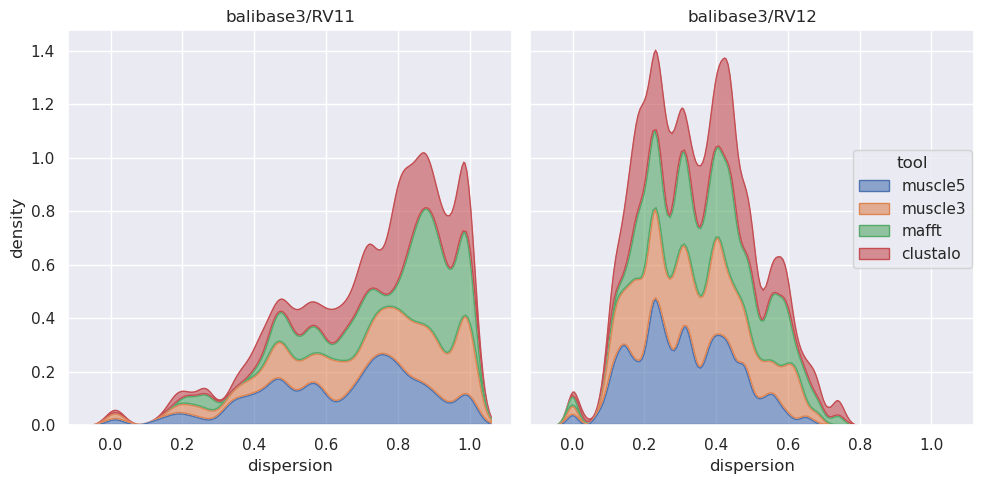

In [ ]:
# import seaborn.objects as so
# import utils.plots as plots

# plot_df = pd.concat((reference_features, aligned_features), axis=0, ignore_index=True)


# out_dir = RESULT_DIR / "plots" / "exploration"
# p = plots.kde_facet_plot(
#     reference_features, x="dispersion", color="tool", facet="benchmark", out_dir=out_dir
# )
# p.show()